# <u> Part 1: Pair Identification

## Install Package

In [1]:
!pip install kneed
from kneed import KneeLocator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

from statsmodels.tsa.stattools import coint

from itertools import cycle

import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

## Data Importing & Cleaning

In [2]:
stockdata = pd.read_excel('commod_data.xlsx')

In [3]:
stockdata["Date"] = pd.to_datetime(stockdata['Date'], format="%Y-%m-%d")

In [4]:
stockdata = stockdata.loc[(stockdata["Date"] >= '2009-01-01')
                     & (stockdata["Date"] < '2017-12-31')]

In [5]:
# Data Import
stockdata = stockdata.iloc[: , 1:].pct_change()
stockdata = stockdata.iloc[1: , :]
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [6]:
# Data Preparation
returns = stockdata.mean()*259
returns = pd.DataFrame(returns)
returns.columns = ['returns']
returns['volatility'] = stockdata.std()*np.sqrt(259)

# Normalization
scale = StandardScaler().fit(returns)
scaled_data = pd.DataFrame(scale.fit_transform(returns),columns = returns.columns, index = returns.index)
X = scaled_data

In [7]:
X.sort_values(by='returns', ascending=False)

,returns,volatility
ELEPJMP,5.388525,3.249884
ELEPJMB,4.916699,3.659100
EEXBASE,1.948366,4.903566
EEXPEAK,1.637127,3.288423
PALLADM,-0.159496,-0.260735
...,...,...
SOYBEAN,-0.270700,-0.303641
PLATFRE,-0.270785,-0.329465
COCINUS,-0.284667,-0.297261
MILKGDA,-0.286840,-0.337971


## Pair Selection

### K-Means Clustering

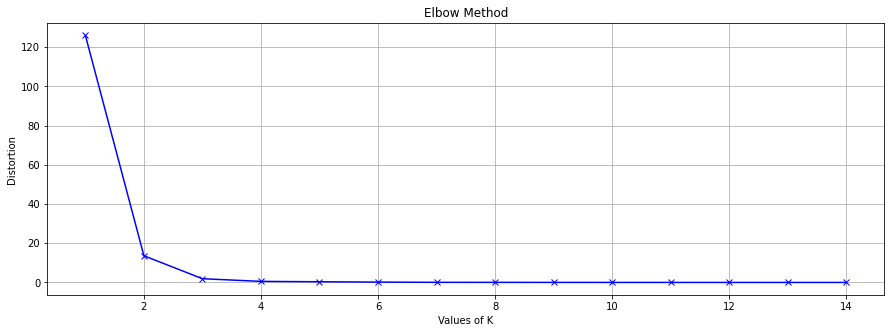

Suggested number of clusters:  3


In [8]:
# Optimize K - Distortion Method
K = range(1,15)
distortions = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

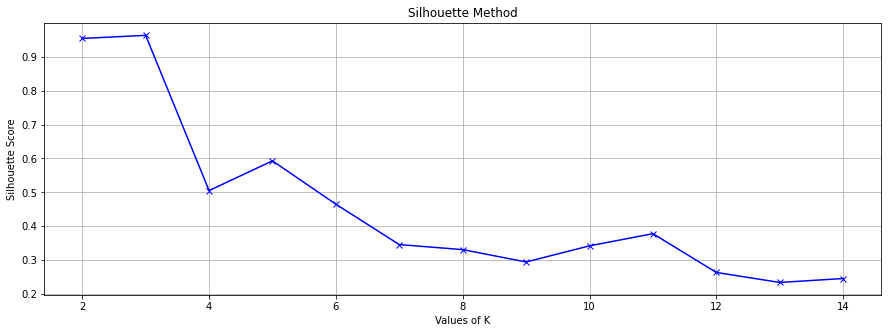

Suggested number of clusters:  4


In [9]:
# Optimize K - Silhouettes Method
K = range(2,15)
silhouettes = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', 4)

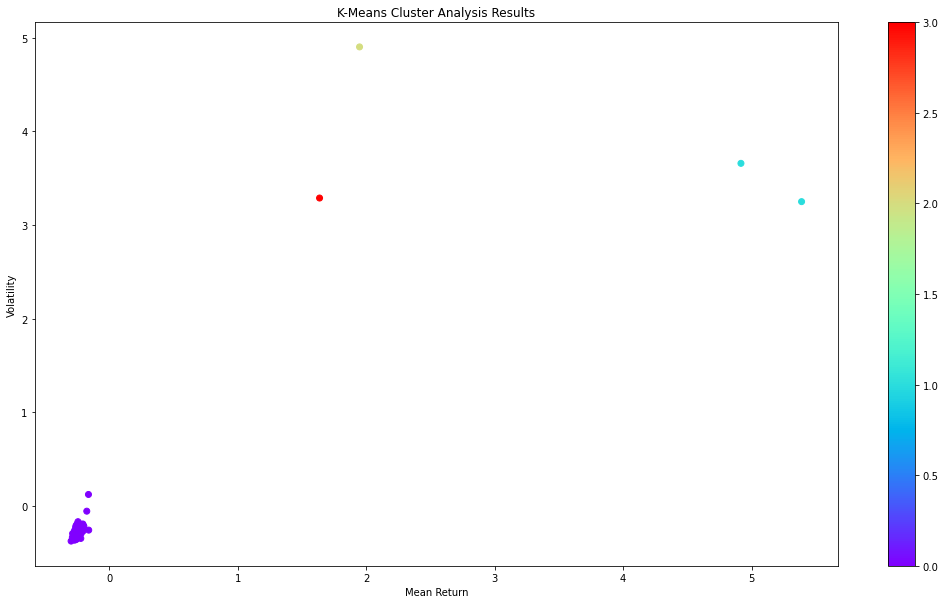

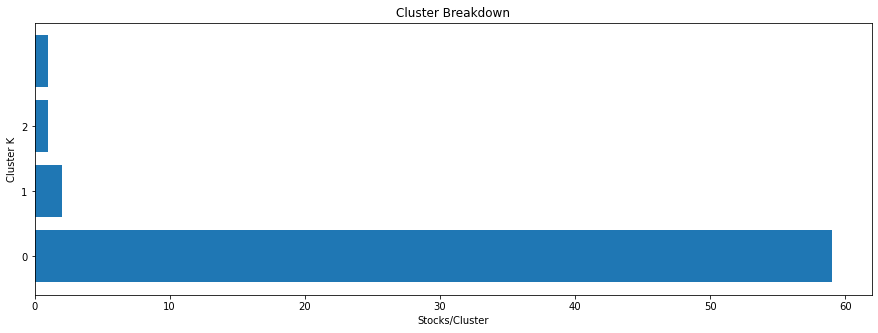

In [10]:
# Optimal K Cluster = 4
c = 4

# Fit Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
labels = k_means.predict(X)

# Plot
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=labels, cmap="rainbow", label = X.index)
ax.set_title('K-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Hierarchical Clustering

Suggested number of clusters:  5


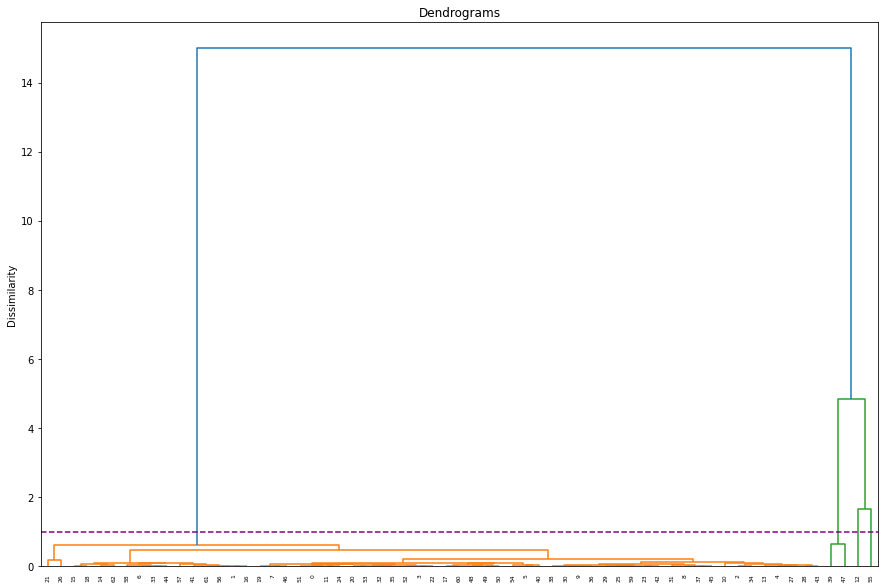

In [11]:
# Optimize Dissimilarity

# Plot
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
plt.ylabel('Dissimilarity')
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=1, color='purple', linestyle='--')

print('Suggested number of clusters: ', 5)

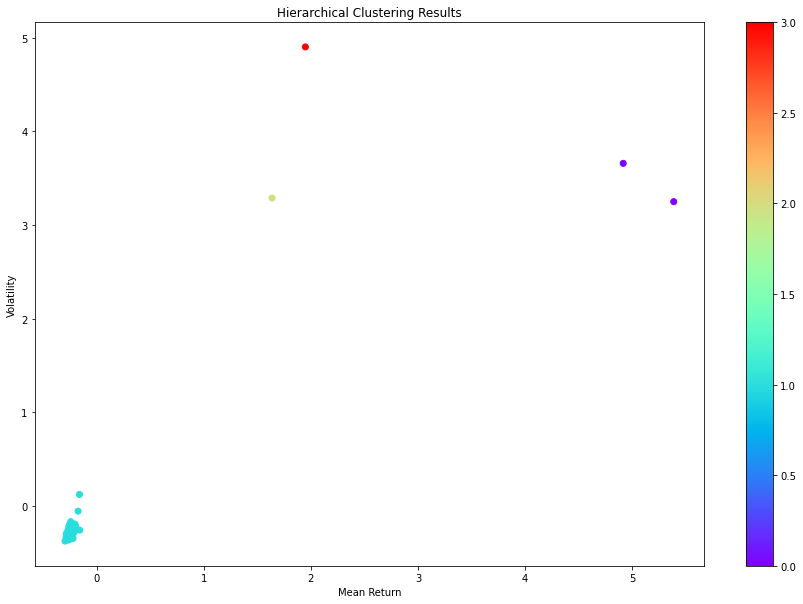

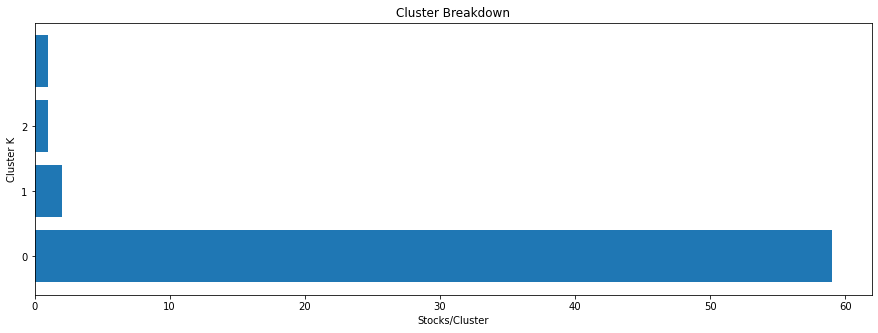

In [12]:
# Fit Model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Affinity Propagation Clustering

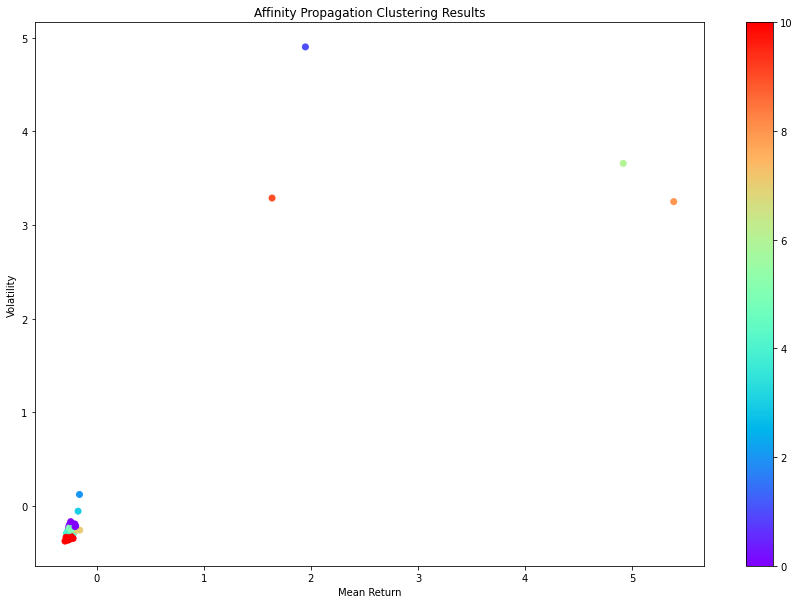

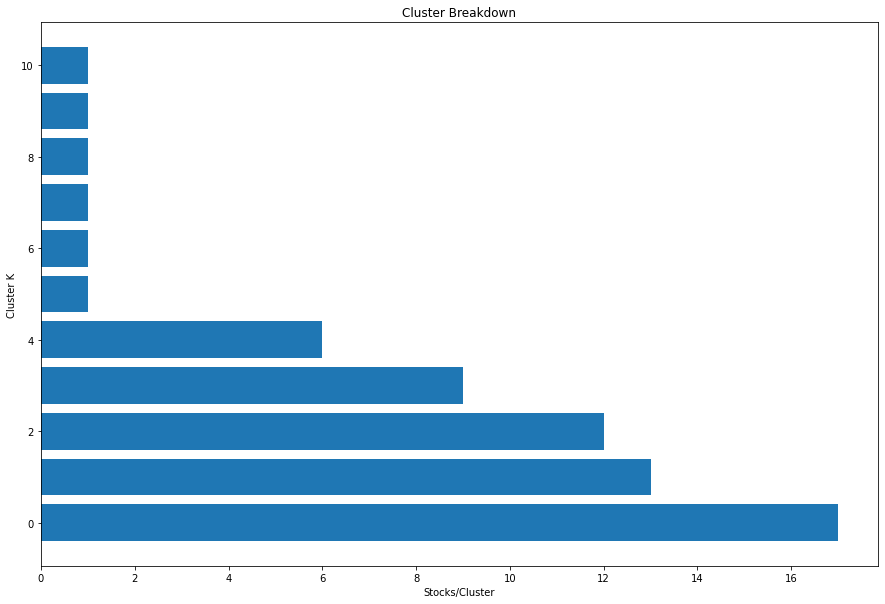

In [13]:
# Fit Model
ap = AffinityPropagation()
ap.fit(X)
labels = ap.predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,10))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
plt.show()

The number of clusters is: 11


<Figure size 432x288 with 0 Axes>

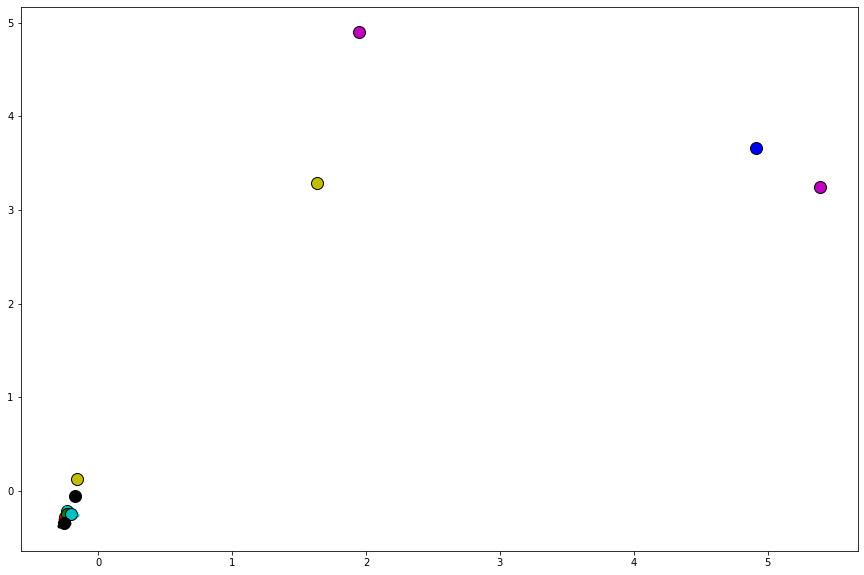

In [14]:
# Extract Cluster Centre
cci = ap.cluster_centers_indices_
labels = ap.labels_
clusters = len(cci)
print('The number of clusters is:',clusters)

# Plot
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.show()

## Clustering Evaluation

In [15]:
print("K-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

K-Means Clustering 0.9431186161563241
Hierarchical Clustering 0.9431186161563241
Affinity Propagation Clustering 0.2974326177112519


## Selection Framework

In [16]:
# Clusters & Pairs Breakdown 
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 5
Number of Pairs: 662


In [17]:
def find_coint_pairs(data, significance=0.01):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [19]:
# Pair Identification
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(stockdata[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print("Number of pairs:", len(pairs))
print("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
pairs

Number of pairs: 52
In those pairs, we found 57 unique tickers.


[('EIAEBRT', 'OILBREN'),
 ('EIAEBRT', 'LNICASH'),
 ('EIAEBRT', 'SILVERH'),
 ('EIAEBRT', 'EIAUSGJ'),
 ('EIAEBRT', 'BFO1MEU'),
 ('EIAEBRT', 'GOEUARA'),
 ('EIAEBRT', 'RHODNWE'),
 ('EIAEBRT', 'COTTONM'),
 ('EIAEBRT', 'EIALALS'),
 ('EIAEBRT', 'EIANYHO'),
 ('EIAEBRT', 'EIANYLS'),
 ('EIAEBRT', 'EIAGCLS'),
 ('EIAEBRT', 'SOYMKCT'),
 ('EIAEBRT', 'DIESELA'),
 ('EIAEBRT', 'FUELOIL'),
 ('EIAEBRT', 'WSUGDLY.1'),
 ('CRUDOIL', 'WHEATSF'),
 ('CRUDOIL', 'OILWTIN'),
 ('CRUDOIL', 'NAFCNWE'),
 ('CRUDOIL', 'COTSCIL'),
 ('CRUDOIL', 'CRUDWTC'),
 ('CRUDOIL', 'ETHANYH'),
 ('CRUDOIL', 'EIATXPR'),
 ('CRUDOIL', 'EIANYGR'),
 ('CRUDOIL', 'EIAGCGR'),
 ('CRUDOIL', 'OILWTXI'),
 ('CRUDOIL', 'NATBGAS'),
 ('CRUDOIL', 'PAOLMAL'),
 ('GOLDBLN', 'LAHCASH'),
 ('GOLDBLN', 'PLATFRE'),
 ('GOLDBLN', 'GOLDHAR'),
 ('GOLDBLN', 'LADCASH'),
 ('GOLDBLN', 'HOGNTMR'),
 ('GOLDBLN', 'LNACASH'),
 ('GOLDBLN', 'DAPNOCB'),
 ('GOLDBLN', 'WSUGDLY'),
 ('GOLDBLN', 'WOLAWCE'),
 ('GOLDBLN', 'USTEERS'),
 ('GOLDBLN', 'MILKGDA'),
 ('LCPCASH', 'CORNUS2')

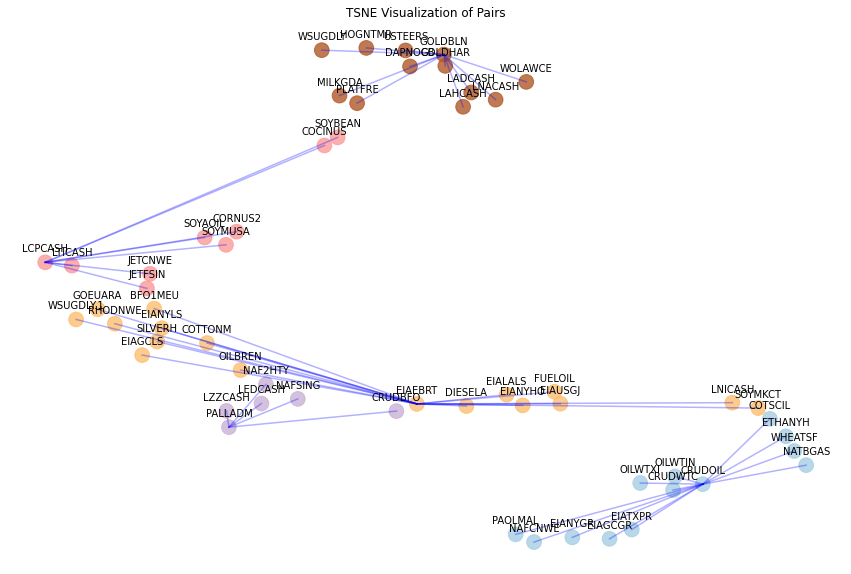

In [20]:
# TSNE Visualization
stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

# Plot
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):
    label = name
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.show()

In [21]:
"""
pairs = pd.DataFrame(pairs)
pairs.to_excel("clustering_pairs.xlsx")

"""

'\npairs = pd.DataFrame(pairs)\npairs.to_excel("clustering_pairs.xlsx")\n\n'

# <u> Part 2: Structural Break Identification

In [22]:
# set theme
import seaborn as sns

plt.style.use('seaborn')
sns.set_style('darkgrid')

In [23]:
# Data import, slicing and transformation

raw_data = pd.read_excel('commod_data.xlsx', sheet_name = 'Sheet1', index_col='Date')

raw_data_returns = np.log(raw_data).diff().dropna()

raw_data_prices = raw_data.dropna(axis=1)
raw_data_prices

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-01,123.26,914.40,8073.0,124.16,123.98,5.83,2884.45,18172.0,5.15,17.57,...,3.4143,1.156113,126.982151,1195.60,831,804.64320,0.1489,1100.0,96.92,1.4400
2008-08-04,121.41,906.20,7734.0,121.87,121.63,5.53,2831.00,17887.0,4.85,17.09,...,3.3251,1.115142,108.001374,1192.80,831,805.80960,0.1423,1050.0,96.94,1.4400
2008-08-05,119.17,880.40,7768.0,116.50,116.88,5.92,2849.50,17474.0,4.75,16.68,...,3.2595,1.085193,110.651676,1192.80,831,792.33120,0.1476,1000.0,96.94,1.4400
2008-08-06,118.58,878.40,7767.0,114.47,114.62,5.83,2855.75,17678.0,4.60,16.50,...,3.2155,1.078347,122.037714,1192.80,831,785.76480,0.1499,1000.0,97.00,1.4400
2008-08-07,120.02,872.85,7810.0,116.94,117.00,6.21,2868.25,18749.0,4.72,16.26,...,3.2115,1.060588,109.358182,1192.80,831,767.87190,0.1456,1015.0,97.59,1.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,99.49,1898.40,9783.8,99.27,102.22,10.71,3073.50,32607.0,7.79,23.60,...,4.2167,1.950124,241.391126,1047.20,473,976.78985,0.1894,1990.0,143.02,1.7550
2022-04-26,101.70,1905.32,9863.5,102.89,105.08,10.92,3048.60,33055.0,7.79,23.54,...,4.5100,2.064209,254.079155,1047.20,473,977.88345,0.1898,1940.0,143.02,1.7075
2022-04-27,102.02,1885.36,9866.5,103.30,105.33,10.90,3080.70,33281.0,7.92,23.37,...,4.8035,1.871173,232.751367,1047.20,473,972.87985,0.1897,1940.0,143.02,1.7275


In [24]:
# Dataframe for unique pairs

unique_pairs = pd.read_excel('final_pairs.xlsx', sheet_name='Sheet1')
selected_pairs = unique_pairs["Concat"].tolist()
print(selected_pairs)
"""
# Using cointegrated pairs with less than 1% p-value

# initializing the list with tuples
string_tuples = pairs

# function that converts tuple to string
def join_tuple_string(strings_tuple) -> str:
    return '-'.join(strings_tuple)

# joining all the tuples
result = map(join_tuple_string, string_tuples)

# converting and printing the result
selected_pairs = list(result)
selected_pairs
"""

['EIAEBRT-OILBREN', 'EIAEBRT-EIAUSGJ', 'EIAEBRT-BFO1MEU', 'EIAEBRT-GOEUARA', 'EIAEBRT-EIALALS', 'EIAEBRT-EIANYHO', 'EIAEBRT-EIANYLS', 'EIAEBRT-EIAGCLS', 'EIAEBRT-DIESELA', 'EIAEBRT-FUELOIL', 'CRUDOIL-OILWTIN', 'CRUDOIL-NAFCNWE', 'CRUDOIL-CRUDWTC', 'CRUDOIL-ETHANYH', 'CRUDOIL-EIANYGR', 'CRUDOIL-EIAGCGR', 'CRUDOIL-OILWTXI', 'GOLDBLN-GOLDHAR', 'LCPCASH-JETCNWE', 'LCPCASH-LTICASH', 'PALLADM-LZZCASH', 'LNICASH-RHODNWE', 'LCPCASH-GOEUARA', 'WHEATSF-NAFCNWE', 'WHEATSF-EIANYGR', 'WHEATSF-EIAGCGR', 'WHEATSF-NATBGAS']


"\n# Using cointegrated pairs with less than 1% p-value\n\n# initializing the list with tuples\nstring_tuples = pairs\n\n# function that converts tuple to string\ndef join_tuple_string(strings_tuple) -> str:\n    return '-'.join(strings_tuple)\n\n# joining all the tuples\nresult = map(join_tuple_string, string_tuples)\n\n# converting and printing the result\nselected_pairs = list(result)\nselected_pairs\n"

## Parsing Function

In [25]:
# Function to parse concatenated pairs 
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

## Visualization of the structural break process using 'EIAEBRT-BFO1MEU' as example

<AxesSubplot:xlabel='Date'>

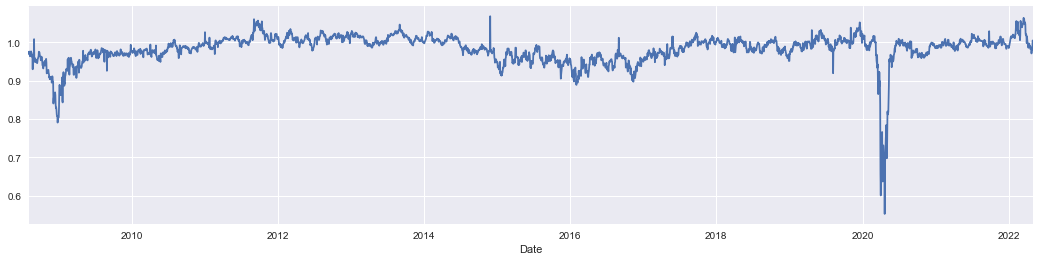

In [26]:
# step 1: we first identify the spread ratio

pair = 'EIAEBRT-BFO1MEU'
s1,s2 = parse_pair(pair)
spread = raw_data_prices[s1]/raw_data_prices[s2]

spread.plot(figsize=(18,4))

In [27]:
# step 2: we fit the model with the given conditions

import statsmodels.api as sm

mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
res = mod.fit(search_reps=100)

In [28]:
print(res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 3586
Model:               MarkovRegression   Log Likelihood                8465.914
Date:                Mon, 20 Jun 2022   AIC                         -16919.828
Time:                        14:14:51   BIC                         -16882.719
Sample:                    08-01-2008   HQIC                        -16906.601
                         - 04-29-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0012      0.000   2950.005      0.000       1.001       1.002
sigma2         0.0002   6.65e-06     23.654      0.0

In [29]:
# Need to research more on the expected durations. Could be used to set the dates for high and low regime periods.

res.expected_durations

array([133.97429442,  96.12812523])

Text(0.5, 1.0, 'Probability of high-mean regime')

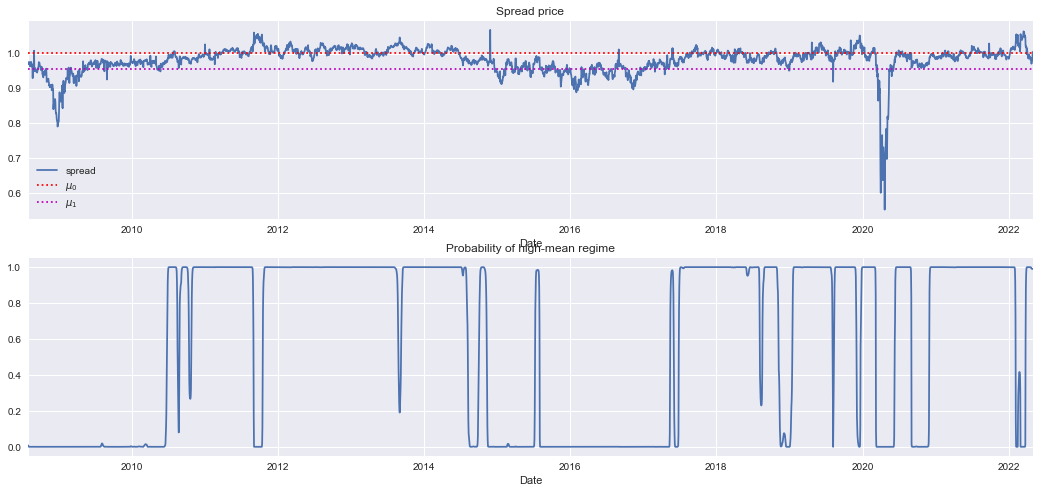

In [30]:
# step 3: we plot the graphs to vizualise the  

fig, axs = plt.subplots(2,1,figsize=(18,8))
spread.plot(ax=axs[0], label='spread')
axs[0].axhline(y=res.params['const[0]'], label=r'$\mu_0$', linestyle='dotted', c='r')
axs[0].axhline(y=res.params['const[1]'], label=r'$\mu_1$', linestyle='dotted', c='m')
axs[0].set_title('Spread price')
axs[0].legend()
res.smoothed_marginal_probabilities[0].plot(ax=axs[1])
axs[1].set_title('Probability of high-mean regime')

## Now, we just run a loop to get the dates of the structural breaks for all pairs for both train and test set

In [31]:
# Function stuctural breaks

def structural_break(pair):
    s1,s2 = parse_pair(pair)
    spread = raw_data_prices[s1]/raw_data_prices[s2]
    
    mod = sm.tsa.MarkovRegression(spread, k_regimes=2,switching_variance=True)
    res = mod.fit(search_reps=100)
    
    regime = pd.DataFrame(res.smoothed_marginal_probabilities)
    regime['Signal'] = regime[0].apply(lambda x: round(x))
    regime['Position'] = regime['Signal'].diff()
    
    dates = []
    for i in range(len(regime)):
        if regime['Position'][i] != 0:
            dates.append(regime.index[i])
    
    break_dates = pd.Series(dates, name=pair)
    
    return break_dates

In [32]:
# Running the function across all the pairs and merging them into one dataframe

struc_break_dates = pd.DataFrame()
#result_train = pd.DataFrame(structural_break_train('EIAEBRT-BFO1MEU'))

for pair in selected_pairs:
    try:
        struc_break_dates = pd.concat([struc_break_dates, structural_break(pair)], axis=1)
  
    except:
        continue

In [33]:
struc_break_dates.head()

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
0,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01
1,2008-09-01,2010-06-28,2009-02-27,2020-03-31,2009-01-12,2008-11-07,2015-12-09,2008-10-23,2010-04-29,2008-10-27,2008-10-21,2008-11-06,2008-08-27,2008-08-26,2008-08-29
2,2008-09-02,2010-08-19,2009-03-19,2020-04-01,2009-01-23,2009-06-05,2016-04-29,2009-03-13,2018-10-31,2018-07-12,2008-11-18,2009-03-23,2008-09-22,2008-10-08,2008-12-19
3,2008-10-15,2010-08-27,2009-04-06,2020-04-21,2009-01-27,2009-07-03,2016-11-08,2009-05-07,NaT,NaT,2009-03-02,2014-12-04,2008-11-11,2008-11-11,2009-03-05
4,2008-10-16,2010-10-15,2011-11-10,2020-04-22,2009-02-05,2009-07-14,2016-12-06,2009-06-24,NaT,NaT,2009-03-20,2015-02-11,2009-05-13,2009-05-14,2009-08-06


In [34]:
struc_break_dates.to_csv("Sructural_Breaks.csv")

# <u> Part 3: Building Trading Models

## 3.1 SVM based upon the two-step Engle–Granger method

In [35]:
final_pairs = struc_break_dates.columns.to_list()
final_pairs

['EIAEBRT-OILBREN',
 'EIAEBRT-BFO1MEU',
 'EIAEBRT-GOEUARA',
 'EIAEBRT-DIESELA',
 'CRUDOIL-NAFCNWE',
 'CRUDOIL-ETHANYH',
 'LCPCASH-JETCNWE',
 'LCPCASH-LTICASH',
 'PALLADM-LZZCASH',
 'LNICASH-RHODNWE',
 'LCPCASH-GOEUARA',
 'WHEATSF-NAFCNWE',
 'WHEATSF-EIANYGR',
 'WHEATSF-EIAGCGR',
 'WHEATSF-NATBGAS']

In [36]:
#Function to get the hedge ratios across the structural breaks for each pair using SVR

from sklearn.svm import LinearSVR

def SVM_regression(pair):
    s1,s2 = parse_pair(pair)
    
    coefficient = []
    
    try:
    
        for i in range(len(struc_break_dates[pair].dropna())):
            s1_price = raw_data_prices[s1].loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]]
            s2_price = raw_data_prices[s2].loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]]

            regressor = LinearSVR()
            res = regressor.fit(np.array(s2_price).reshape(-1,1), np.array(s1_price).reshape(-1,1).ravel())

            coefficient += res.coef_.flatten().tolist()
            
    except:
        pass
    
    hedge_ratios = pd.Series(coefficient, name=pair)
        
    return hedge_ratios

In [37]:
# Running the function across all the pairs and merging them into one dataframe

hedge_ratios = pd.DataFrame()

for pair in final_pairs:
    hedge_ratios = pd.concat([hedge_ratios, SVM_regression(pair)], axis=1)
    
hedge_ratios.head()

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
0,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
1,0.994591,0.989755,0.112755,2.061500,0.112672,21.430623,13.326654,0.303608,0.262526,11.948298,6.009783,0.014635,1.499369,1.126030,1.793320
2,0.992717,0.980811,0.109896,9.545173,0.115760,28.120370,10.279717,0.369684,NaN,NaN,7.212098,0.008489,1.290491,0.963086,0.799166
3,0.949618,0.983638,0.119551,1.296800,0.098484,14.180000,12.297669,0.340941,NaN,NaN,9.987608,0.013156,1.242952,1.293877,2.189674
4,0.999219,0.979473,0.112040,NaN,0.125266,29.789151,11.154214,0.394832,NaN,NaN,8.453820,0.008533,2.020676,2.097779,4.442524


### Now, we want to generate the spread for each pair across the entire sample period based on the previously generated hedge ratios from the SVR model.

### $$ Spread = log(a) – nlog(b)$$,  where ‘a’ and ‘b’ are prices of futures A and B respectively, and n is the regression coefficient (hedge ratio)

In [38]:
# So we start by creating a function for generating the hedge ratio against the sample period

def hedge_ratio(pair):
    s1,s2 = parse_pair(pair)
    try:
        date_hedge = pd.DataFrame()

        for i in range(len(struc_break_dates[pair].dropna())):
            hedge_ratio_df = raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]].index.to_frame(index=False, name='Date')
            hedge_ratio_df[pair] = hedge_ratios[pair][i]

            date_hedge = date_hedge.append(hedge_ratio_df)
            
        date_hedge = pd.concat([date_hedge, raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:raw_data_prices[s1].index[-1]].index.to_frame(index=False, name='Date')])
        
    except:
        pass

    return date_hedge.append(raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:raw_data_prices[s1].index[-1]].index.to_frame(index=False))

In [39]:
# Next we run the function against all the pairs
merged_hedge_ratios = hedge_ratio('EIAEBRT-OILBREN')
for pair in final_pairs[1:]:
    merged_hedge_ratios = pd.merge(merged_hedge_ratios,hedge_ratio(pair), on='Date')

In [40]:
# applying ffill() method to fill the missing values, dropping duplicates and setting date as index so as to get a complete hedge ratio dataframe
merged_hedge_ratios = merged_hedge_ratios.ffill(axis = 0)
merged_hedge_ratios = merged_hedge_ratios.drop_duplicates(subset='Date')
merged_hedge_ratios = merged_hedge_ratios.set_index('Date')
merged_hedge_ratios

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2008-08-01,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
2008-08-04,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
2008-08-05,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
2008-08-06,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
2008-08-07,0.993651,1.049342,0.114958,40.242146,0.118744,38.497822,7.802004,0.380234,0.150663,3.148055,7.643015,0.006217,1.849014,1.808773,2.488192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,1.020330,1.031802,0.124776,1.296800,0.116140,23.411920,15.779207,0.344371,0.262526,11.948298,12.606607,0.008290,2.506092,2.547236,0.580364
2022-04-26,1.020330,1.031802,0.124776,1.296800,0.116140,23.411920,15.779207,0.344371,0.262526,11.948298,12.606607,0.008290,2.506092,2.547236,0.580364
2022-04-27,1.020330,1.031802,0.124776,1.296800,0.116140,23.411920,15.779207,0.344371,0.262526,11.948298,12.606607,0.008290,2.506092,2.547236,0.580364


In [41]:
# Now we can proceed to generate a function to calcuate the spread series for each pair

def spread_series(pair):
    s1,s2 = parse_pair(pair)
    
    spread_series = np.log(raw_data_prices[s1]) - (merged_hedge_ratios[pair] * np.log(raw_data_prices[s2]))
    
    return spread_series

In [42]:
# Creation of the spread dataframe

spread_df = pd.DataFrame()

for pair in final_pairs:
    spread_df[pair] = spread_series(pair) 
spread_df

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2008-08-01,0.032054,-0.264360,4.014572,-44.720594,3.988811,-34.269874,-46.584217,5.202257,4.773284,-18.552676,-44.657435,1.719799,-0.275099,-0.250459,1.402071
2008-08-04,0.032453,-0.264687,3.996084,-43.945389,3.979511,-34.284997,-46.639677,5.177055,4.760533,-18.480625,-44.691790,1.667275,-0.268016,-0.249615,1.439021
2008-08-05,0.026972,-0.266785,3.957691,-43.068008,3.962088,-34.303619,-46.174837,5.190609,4.745691,-18.464136,-44.243899,1.735486,-0.170456,-0.166099,1.574908
2008-08-06,0.028795,-0.264431,3.941484,-42.393018,3.957125,-34.308582,-46.091307,5.182701,4.771927,-18.412169,-44.152887,1.720167,-0.194135,-0.181418,1.575334
2008-08-07,0.029722,-0.260391,3.962172,-41.837989,3.970773,-34.296512,-45.987603,5.187389,4.747167,-18.353349,-44.191249,1.783393,-0.180993,-0.150094,1.679796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,-0.123354,-0.176435,3.722284,2.818249,3.817073,-26.654881,-103.105776,5.537691,5.465182,-106.934773,-79.272807,2.315288,-0.567946,-0.580474,1.983557
2022-04-26,-0.115692,-0.169090,3.751564,2.799756,3.836092,-26.632910,-103.890535,5.539782,5.497037,-106.790472,-79.925164,2.334495,-0.636925,-0.646744,1.969979
2022-04-27,-0.114140,-0.167565,3.753880,2.769630,3.835523,-26.629769,-104.161877,5.543581,5.525421,-106.783658,-80.092649,2.332397,-0.703068,-0.714961,2.025126


In [43]:
# Train-test split

form_start = '2008-08-01'
form_end = '2021-07-31'
trade_start = '2021-08-01'
trade_end = '2022-04-29'

prices_train = raw_data_prices[form_start:form_end]
prices_test = raw_data_prices[trade_start:trade_end]
returns_train = raw_data_returns.loc[form_start:form_end]
returns_test = raw_data_returns.loc[trade_start:trade_end]

### Now that we have our spreads, we can generate our 'Signals'.

So essentiallty our signal generated based on the 30-day rolling mean plus the 30-day rolling standard deviation. So if the spread at t is greater than this "sum of rolling" then we take a short position and vice versa.

In [44]:
def signals(pair, spread_df):
    s1,s2 = parse_pair(pair)
    
    df = spread_df[pair].to_frame()
    df['sum of rolling'] = df[pair].rolling(window=30).mean() + df[pair].rolling(window=30).std()
    df['Signals'] = 0
    df = df.dropna()
    
    for i in range(len(df[pair])):
        if df[pair][i] > df['sum of rolling'][i]:
            df['Signals'][i] = 0
        elif df[pair][i] < df['sum of rolling'][i]:
            df['Signals'][i]= 1
    
    pair_signals = pd.Series(df['Signals'], name=pair)
    
    return pair_signals

In [45]:
# Train-test split for the spread df

spread_train = spread_df[form_start:form_end]
spread_test = spread_df[trade_start:trade_end]

In [46]:
# Now to create a dataframe of positions for the final pairs
pair_signals_train = pd.DataFrame()

for pair in final_pairs:
    pair_signals_train[pair] = signals(pair, spread_train)

pair_signals_train.head()

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2008-09-11,1,1,1,0,1.0,1.0,0,1,1,0,0,1,1,1,1
2008-09-12,1,1,1,0,1.0,0.0,0,1,1,0,0,1,1,1,1
2008-09-15,1,1,1,0,1.0,0.0,0,1,1,0,0,1,1,1,1
2008-09-16,1,1,1,0,1.0,0.0,0,1,1,0,0,1,1,1,1
2008-09-17,1,1,1,0,1.0,0.0,0,1,1,0,0,1,0,0,1


In [47]:
pair_positions_train = pair_signals_train.diff().dropna()
pair_positions_train.head()

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2008-09-12,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
2008-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [48]:
# Now to create a dataframe of positions for the final pairs for test set
pair_signals_test = pd.DataFrame()

for pair in final_pairs:
    pair_signals_test[pair] = signals(pair, spread_test)

pair_signals_test

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2021-09-10,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1
2021-09-13,1,1,1,1,0,1,1,0,1,0,1,1,0,0,1
2021-09-14,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1
2021-09-15,1,1,0,1,0,1,1,0,1,0,1,1,0,1,1
2021-09-16,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
2022-04-26,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
2022-04-27,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0


In [49]:
pair_positions_test = pair_signals_test.diff().dropna()
pair_positions_test

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS
Date,,,,,,,,,,,,,,,
2021-09-13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-15,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
2022-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Back-Testing

Basically, if the position is -1, then we are shorting the spread and hence price of s2 times quantity which in this case is a 100 x hedge ratio. The rationale is that we sell 100 shares of s1 and the equivalent nominal quantity we need to buy of s2 is 100 x hedge ratio. Vice-versa for when we want to long the spread.

In [50]:
def profit_train(pair):
    s1,s2 = parse_pair(pair)
    
    series = pd.Series(merged_hedge_ratios[pair], name = 'Hedge Ratio')
    combine_df = pd.concat([prices_train[s1], prices_train[s2], pair_positions_train[pair], series], axis=1).dropna()
    
    combine_df['PnL'] = 0

    for i in range(len(combine_df)):
        if combine_df[pair][i] == -1:
            combine_df['PnL'][i] = (100*combine_df['Hedge Ratio'][i]*combine_df[s2][i]) - (100*combine_df[s1][i])
        elif combine_df[pair][i] == 1:
            combine_df['PnL'][i] =  (100*combine_df[s1][i]) - (100*combine_df['Hedge Ratio'][i]*combine_df[s2][i])
        else:
            combine_df['PnL'][i] = 0
            
    PnL = pd.Series(combine_df['PnL'], name=pair)
    
    return PnL

In [51]:
def profit_test(pair):
    s1,s2 = parse_pair(pair)
    
    series = pd.Series(merged_hedge_ratios[pair], name = 'Hedge Ratio')
    combine_df = pd.concat([prices_test[s1], prices_test[s2], pair_positions_test[pair], series], axis=1).dropna()
    
    combine_df['PnL'] = 0

    for i in range(len(combine_df)):
        if combine_df[pair][i] == -1:
            combine_df['PnL'][i] = (100*combine_df['Hedge Ratio'][i]*combine_df[s2][i]) - (100*combine_df[s1][i])
        elif combine_df[pair][i] == 1:
            combine_df['PnL'][i] =  (100*combine_df[s1][i]) - (100*combine_df['Hedge Ratio'][i]*combine_df[s2][i])
        else:
            combine_df['PnL'][i] = 0
            
    PnL = pd.Series(combine_df['PnL'], name=pair)
    
    return PnL

In [52]:
profit_train(pair)

Date
2008-09-12    0
2008-09-15    0
2008-09-16    0
2008-09-17    0
2008-09-18    0
             ..
2021-07-26    0
2021-07-27    0
2021-07-28    0
2021-07-29    0
2021-07-30    0
Name: WHEATSF-NATBGAS, Length: 3330, dtype: int64

## Accumulated Profit for the period

In [53]:
pair_profits_train = pd.DataFrame()

for pair in merged_hedge_ratios.columns:
    pair_profits_train[pair] = profit_train(pair)

pair_profits_train.sum()

EIAEBRT-OILBREN      -11601
EIAEBRT-BFO1MEU       -7826
EIAEBRT-GOEUARA       -9192
EIAEBRT-DIESELA      -12956
CRUDOIL-NAFCNWE      -25577
CRUDOIL-ETHANYH      -25253
LCPCASH-JETCNWE     -826366
LCPCASH-LTICASH    -1406363
PALLADM-LZZCASH      -19966
LNICASH-RHODNWE    10974531
LCPCASH-GOEUARA     -615009
WHEATSF-NAFCNWE       -1347
WHEATSF-EIANYGR        -220
WHEATSF-EIAGCGR        -487
WHEATSF-NATBGAS         -80
dtype: int64

In [54]:
pair_profits_train['Daily PnL'] = pair_profits_train.sum(axis=1)
pair_profits_train['Daily PnL'].sum()

8012288

In [55]:
pair_profits_test = pd.DataFrame()

for pair in merged_hedge_ratios.columns:
    pair_profits_test[pair] = profit_test(pair)

pair_profits_test.sum()

EIAEBRT-OILBREN       -743
EIAEBRT-BFO1MEU       -345
EIAEBRT-GOEUARA       -220
EIAEBRT-DIESELA       6828
CRUDOIL-NAFCNWE      -3068
CRUDOIL-ETHANYH       -617
LCPCASH-JETCNWE     -31638
LCPCASH-LTICASH    -343635
PALLADM-LZZCASH     -22860
LNICASH-RHODNWE    4016228
LCPCASH-GOEUARA     -48333
WHEATSF-NAFCNWE         34
WHEATSF-EIANYGR        -87
WHEATSF-EIAGCGR        -32
WHEATSF-NATBGAS       -775
dtype: int64

In [56]:
pair_profits_test['Daily PnL'] = pair_profits_test.sum(axis=1)
pair_profits_test['Daily PnL'].sum()

3570737

<AxesSubplot:xlabel='Date'>

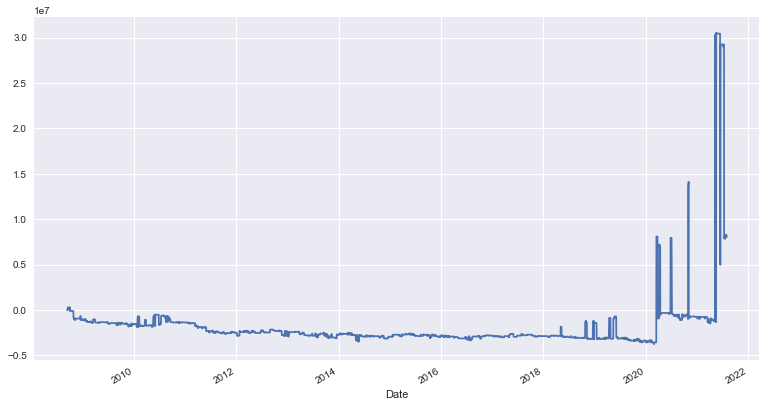

In [57]:
pair_profits_train['Daily PnL'].cumsum().plot(figsize=(13,7))

<AxesSubplot:xlabel='Date'>

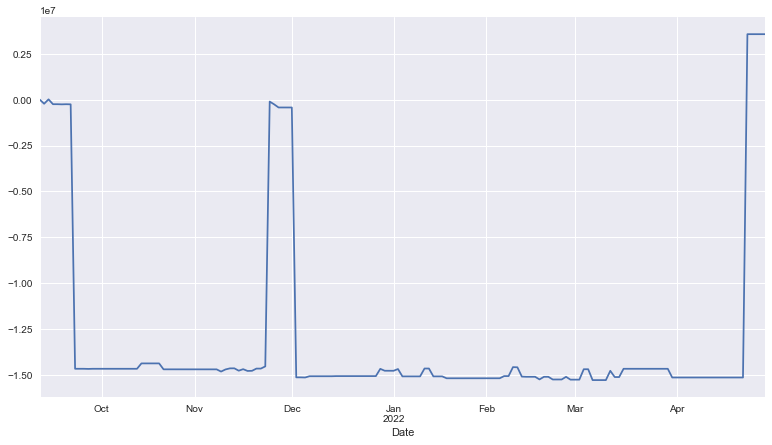

In [58]:
pair_profits_test['Daily PnL'].cumsum().plot(figsize=(13,7))

## <u>  Performance Metrics

### Top 3 performing pairs

In [59]:
# Best performing pairs in the train set

pair_profits_train[pair_profits_train.columns[:-1]].sum().nlargest(3)

LNICASH-RHODNWE    10974531
WHEATSF-NATBGAS         -80
WHEATSF-EIANYGR        -220
dtype: int64

In [60]:
# Best performing pairs in the test set

pair_profits_test[pair_profits_test.columns[:-1]].sum().nlargest(3)

LNICASH-RHODNWE    4016228
EIAEBRT-DIESELA       6828
WHEATSF-NAFCNWE         34
dtype: int64

In [61]:
# Initialising capital

initial_capital = float(100000)

In [62]:
# Generating terminal wealth for train set

pair_profits_train['Terminal Wealth'] = initial_capital + pair_profits_train['Daily PnL'].cumsum()
pair_profits_train

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS,Daily PnL,Terminal Wealth
Date,,,,,,,,,,,,,,,,,
2008-09-12,0,0,0,0,0,-1378,0,0,0,0,0,0,0,0,0,-1378,98622.0
2008-09-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,98622.0
2008-09-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,98622.0
2008-09-17,0,0,0,0,0,0,0,0,0,0,0,0,-118,-181,0,-299,98323.0
2008-09-18,0,0,0,0,0,0,0,0,0,293966,0,0,30,0,0,293996,392319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,0,0,0,0,0,0,0,251661,0,0,0,0,0,0,0,251661,8364912.0
2021-07-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8364912.0
2021-07-28,0,0,0,0,0,0,0,-246300,0,0,0,0,0,0,0,-246300,8118612.0


In [63]:
# Generating terminal wealth for test set

pair_profits_test['Terminal Wealth'] = initial_capital + pair_profits_test['Daily PnL'].cumsum()
pair_profits_test

,EIAEBRT-OILBREN,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-DIESELA,CRUDOIL-NAFCNWE,CRUDOIL-ETHANYH,LCPCASH-JETCNWE,LCPCASH-LTICASH,PALLADM-LZZCASH,LNICASH-RHODNWE,LCPCASH-GOEUARA,WHEATSF-NAFCNWE,WHEATSF-EIANYGR,WHEATSF-EIAGCGR,WHEATSF-NATBGAS,Daily PnL,Terminal Wealth
Date,,,,,,,,,,,,,,,,,
2021-09-13,0,0,0,7011,0,0,0,0,0,0,0,0,0,0,0,7011,107011.0
2021-09-14,0,0,0,0,0,0,0,-228510,0,0,0,0,0,416,0,-228094,-121083.0
2021-09-15,0,0,236,0,0,0,0,239021,0,0,0,0,0,0,0,239257,118174.0
2021-09-16,0,0,0,0,0,0,0,-264248,0,0,0,0,452,0,0,-263796,-145622.0
2021-09-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-145622.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0,0,0,0,0,0,0,0,0,18712219,0,0,0,0,0,18712219,3670737.0
2022-04-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3670737.0
2022-04-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3670737.0


### Generating backtesting performance tear sheet

In [64]:
import pyfolio as pf

Start date,2008-09-15
End date,2021-07-30
Total months,158
,Backtest
Annual return,39.6%
Cumulative returns,8125.6%
Annual volatility,1782.1%
Sharpe ratio,-0.28
Calmar ratio,0.04
Stability,NaN
Max drawdown,-970.6%


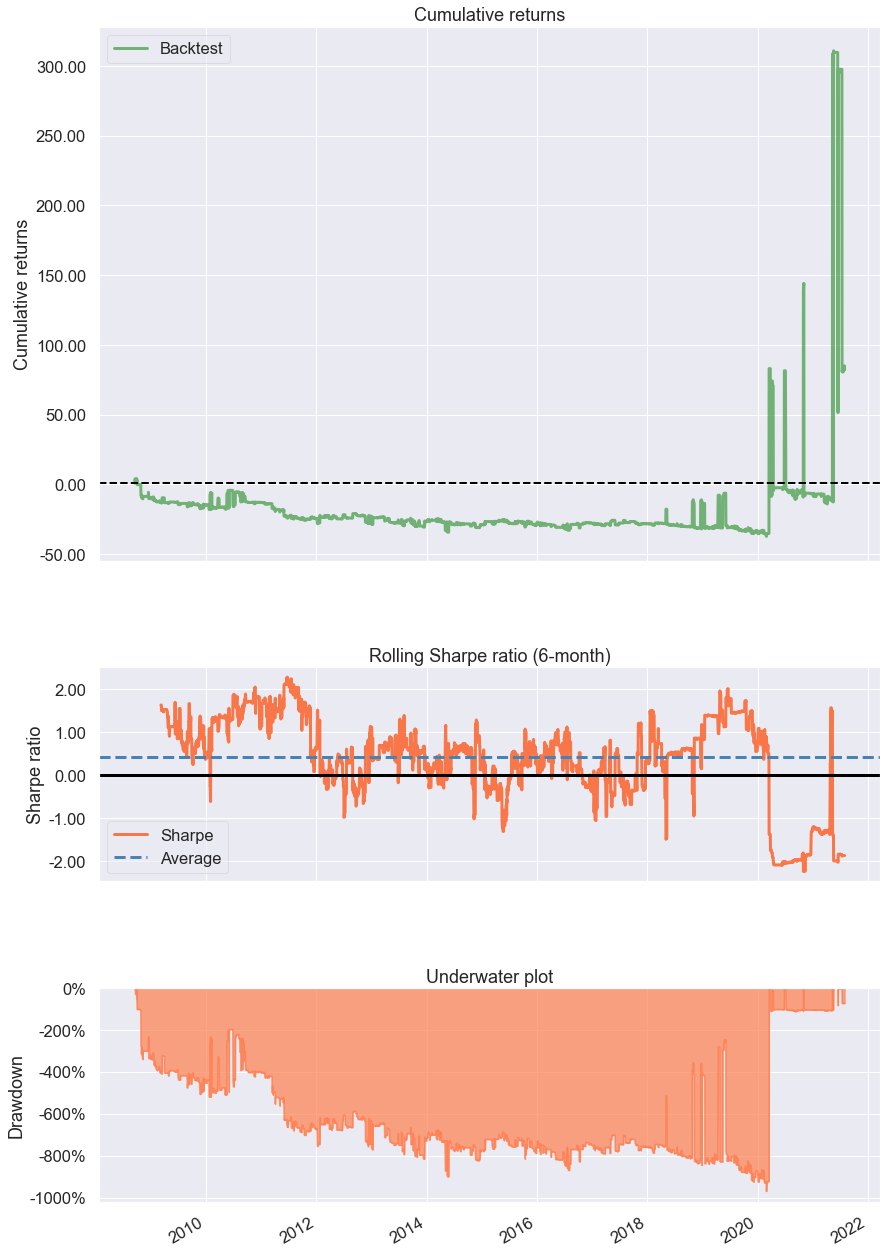

In [65]:
pf.create_simple_tear_sheet(pair_profits_train['Terminal Wealth'].pct_change().dropna())

Start date,2021-09-14
End date,2022-04-29
Total months,7
,Backtest
Annual return,22764.3%
Cumulative returns,3330.2%
Annual volatility,13854.3%
Sharpe ratio,1.92
Calmar ratio,1.76
Stability,NaN
Max drawdown,-12948.3%


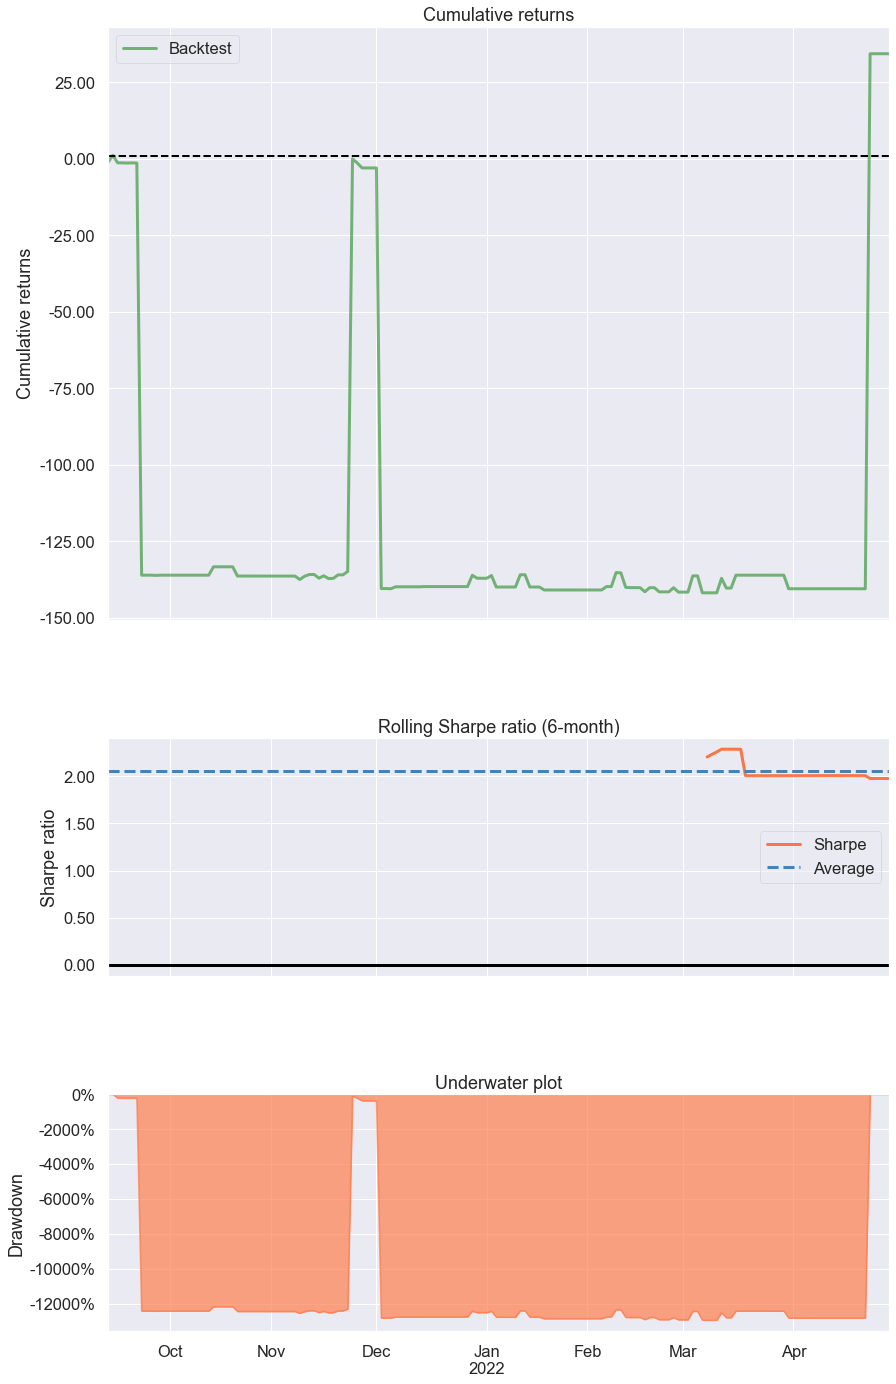

In [69]:
pf.create_simple_tear_sheet(pair_profits_test['Terminal Wealth'].pct_change().dropna())